In [1]:
import pandas as pd

# -----------------------------
# 1. Load all GTFS-related files
# -----------------------------


# Explicit variables for convenience when working in notebooks or scripts.
calendar_dates = pd.read_csv("data/calendar_dates.txt")
calendar = pd.read_csv("data/calendar.txt")

direction_names_exceptions = pd.read_csv("data/direction_names_exceptions.txt")
directions = pd.read_csv("data/directions.txt")

route_names_exceptions = pd.read_csv("data/route_names_exceptions.txt")
routes = pd.read_csv("data/routes.txt")

shapes = pd.read_csv("data/shapes.txt")
signup_periods = pd.read_csv("data/signup_periods.txt")

stop_order_exceptions = pd.read_csv("data/stop_order_exceptions.txt")
stop_times = pd.read_csv("data/stop_times.txt")
stops = pd.read_csv("data/stops.txt")
transfers = pd.read_csv("data/transfers.txt")
trips = pd.read_csv("data/trips.txt")


In [2]:
# 2. Null Check

dfs = [calendar_dates, calendar, 
       direction_names_exceptions, 
       directions, 
       route_names_exceptions, routes, shapes, signup_periods, 
       stop_order_exceptions, stop_times, stops, transfers, trips] 

for i, df in enumerate(dfs, start=1):
    print(f"\nDataFrame {i}")
    print(df.isnull().sum())


DataFrame 1
service_id        0
date              0
exception_type    0
dtype: int64

DataFrame 2
service_id    0
monday        0
tuesday       0
wednesday     0
thursday      0
friday        0
saturday      0
sunday        0
start_date    0
end_date      0
dtype: int64

DataFrame 3
route_name        0
direction_id      0
direction_name    0
direction_do      0
dtype: int64

DataFrame 4
direction           0
direction_id        0
route_id            0
route_short_name    0
LineIdConst         0
dtype: int64

DataFrame 5
route_id       0
route_name     0
route_do      33
name_type      0
dtype: int64

DataFrame 6
route_id              0
agency_id             0
route_short_name      4
route_long_name       0
route_desc          242
route_type            0
route_url           242
route_color         230
route_text_color    230
dtype: int64

DataFrame 7
shape_id               0
shape_pt_lat           0
shape_pt_lon           0
shape_pt_sequence      0
shape_dist_traveled    0
dtype: int64

In [3]:
for i, df in enumerate(dfs, start=1):
    print(f"\nDataFrame {i}")
    print(df.shape[0])


DataFrame 1
732

DataFrame 2
27

DataFrame 3
493

DataFrame 4
502

DataFrame 5
33

DataFrame 6
242

DataFrame 7
220017

DataFrame 8
2

DataFrame 9
82

DataFrame 10
1833708

DataFrame 11
8817

DataFrame 12
10423

DataFrame 13
62537


In [6]:

# Join onto trips (trips is the “big” table, so start from it)
calendar_trips = (
    trips
    .merge(calendar, on="service_id", how="left", validate="many_to_one")
)

calendar_trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,6612,1,14827490,2 Macdonald/To Burrard Station,NaN,0,2159340.0,309728,0,1,1,1,1,1,1,0,0,20260105,20260419
1,6612,1,14827491,2 Macdonald/To Burrard Station,NaN,0,2159341.0,309728,0,1,1,1,1,1,1,0,0,20260105,20260419
2,6612,1,14827492,2 Macdonald/To Burrard Station,NaN,0,2159339.0,309728,0,1,1,1,1,1,1,0,0,20260105,20260419
3,6612,1,14827493,2 Macdonald/To Burrard Station,NaN,0,2159335.0,309728,0,1,1,1,1,1,1,0,0,20260105,20260419
4,6612,1,14827494,2 Macdonald/To Burrard Station,NaN,0,2159340.0,309728,0,1,1,1,1,1,1,0,0,20260105,20260419


In [30]:
# Split HH:MM:SS into columns
hms = stop_times["arrival_time"].str.split(":", expand=True).astype(int)

# Convert to total seconds
stop_times["arrival_sec"] = (
    hms[0] * 3600 +
    hms[1] * 60 +
    hms[2]
)

hms_dep = stop_times["departure_time"].str.split(":", expand=True).astype(int)

stop_times["departure_sec"] = (
    hms_dep[0] * 3600 +
    hms_dep[1] * 60 +
    hms_dep[2]
)

trip_duration = (
    stop_times
    .groupby("trip_id", as_index=False)
    .agg(
        start_time=("departure_sec", "min"),
        end_time=("arrival_sec", "max")
    )
)

trip_duration["trip_duration_min"] = (
    (trip_duration["end_time"] - trip_duration["start_time"]) / 60
)

trips_final = trips.merge(
    trip_duration[["trip_id", "trip_duration_min"]],
    on="trip_id",
    how="left",
    validate="one_to_one"
)

trips_info_for_analysis = trips_final[["route_id", "trip_id", "trip_headsign", "trip_duration_min"]]
trips_info_for_analysis

,route_id,trip_id,trip_headsign,trip_duration_min
0,6612,14827490,2 Macdonald/To Burrard Station,25.0
1,6612,14827491,2 Macdonald/To Burrard Station,27.0
2,6612,14827492,2 Macdonald/To Burrard Station,30.0
3,6612,14827493,2 Macdonald/To Burrard Station,30.0
4,6612,14827494,2 Macdonald/To Burrard Station,30.0
...,...,...,...,...
62532,6692,15073635,255 Park Royal Only,29.0
62533,6692,15073636,255 Park Royal Only,30.0
62534,6692,15073637,255 Park Royal Only,38.0
62535,6692,15073638,255 Park Royal Only,38.0


In [33]:
print(trips["trip_headsign"].unique().shape[0])
print((trips_final["trip_duration_min"] < 0).sum())

619
0


In [35]:
avg_duration_by_headsign = (
    trips_info_for_analysis
    .groupby("trip_headsign", as_index=False)
    .agg(
        avg_trip_duration_min=("trip_duration_min", "mean"),
        trip_count=("trip_id", "count")   # optional but useful
    )
)

avg_duration_by_headsign.head()

,trip_headsign,avg_trip_duration_min,trip_count
0,321 King George Blvd/To Scott Rd Station,77.360000,25
1,10 Granville/To Davie St,27.800000,5
2,10 Granville/To Marine Dr Station,44.705882,238
3,10 Granville/To Marpole Loop,34.000000,8
4,10 Granville/To Waterfront Station,45.540000,250


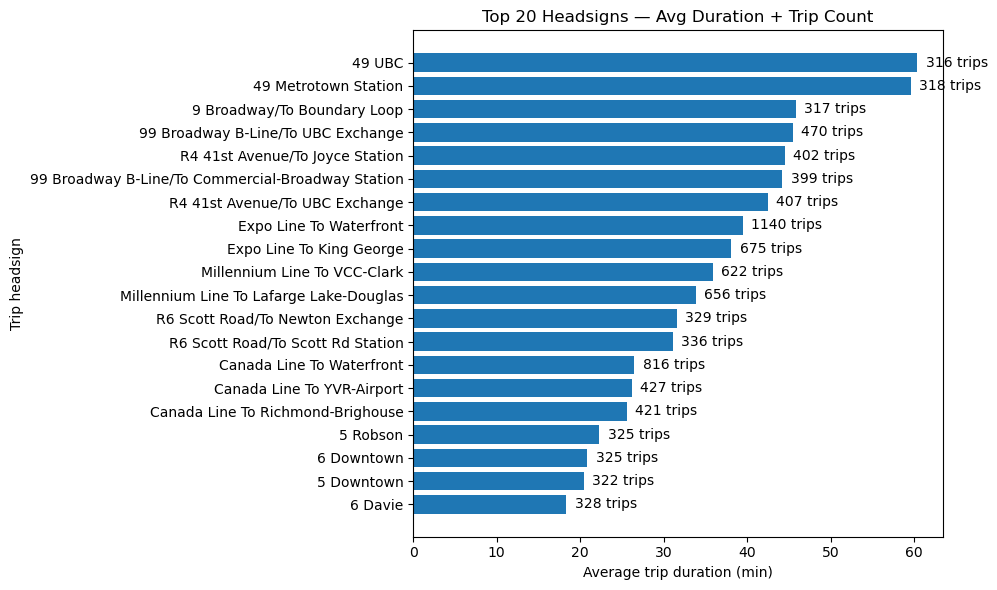

In [36]:
import matplotlib.pyplot as plt

topN = 20
plot_df = avg_duration_by_headsign.nlargest(topN, "trip_count") \
                                   .sort_values("avg_trip_duration_min")

plt.figure(figsize=(10, 6))
bars = plt.barh(plot_df["trip_headsign"], plot_df["avg_trip_duration_min"])

# Add trip count text to the right of each bar
for i, (duration, count) in enumerate(zip(plot_df["avg_trip_duration_min"],
                                          plot_df["trip_count"])):
    plt.text(duration + 1, i, f"{count} trips", va='center')

plt.xlabel("Average trip duration (min)")
plt.ylabel("Trip headsign")
plt.title(f"Top {topN} Headsigns — Avg Duration + Trip Count")
plt.tight_layout()
plt.show()

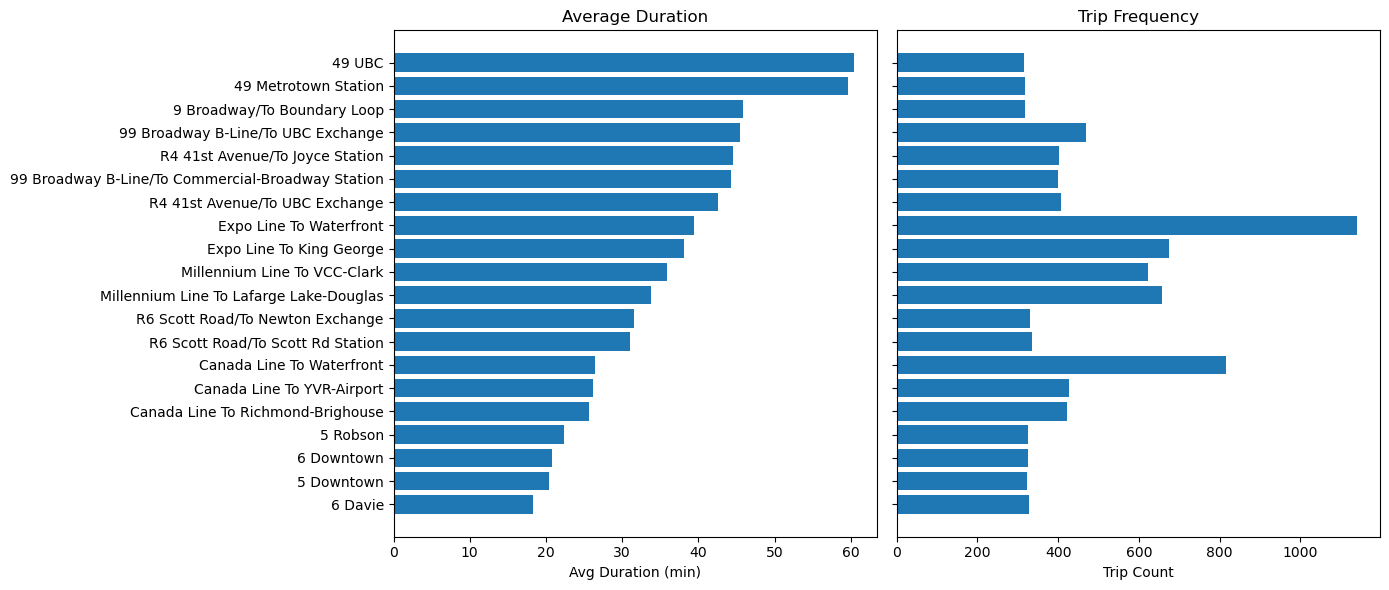

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Duration bars
ax1.barh(plot_df["trip_headsign"], plot_df["avg_trip_duration_min"])
ax1.set_xlabel("Avg Duration (min)")
ax1.set_title("Average Duration")

# Trip count bars
ax2.barh(plot_df["trip_headsign"], plot_df["trip_count"])
ax2.set_xlabel("Trip Count")
ax2.set_title("Trip Frequency")

plt.tight_layout()
plt.show()

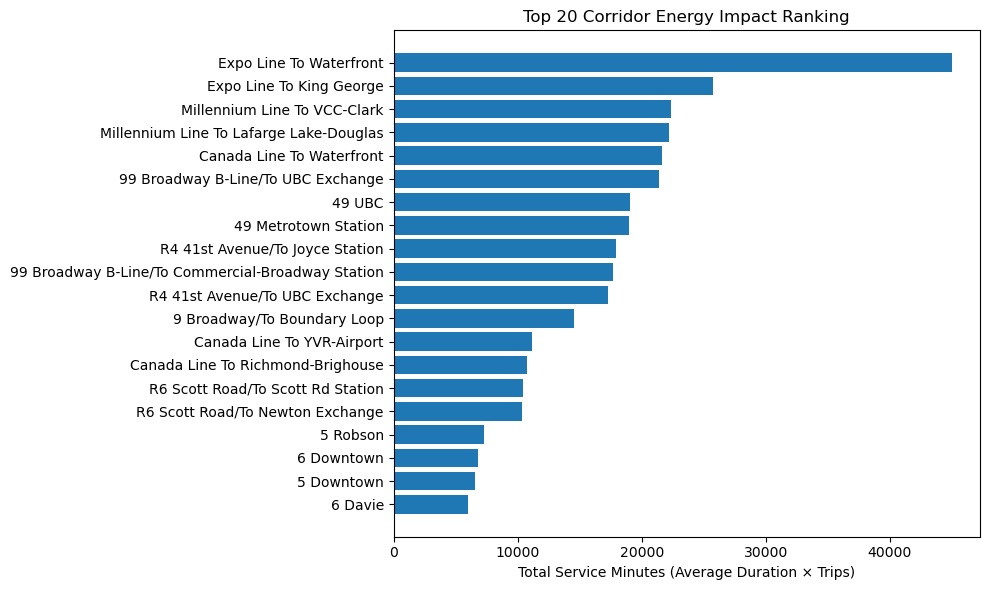

In [40]:
plot_df["service_minutes"] = (
    plot_df["avg_trip_duration_min"] *
    plot_df["trip_count"]
)

plot_df = plot_df.sort_values("service_minutes")

plt.figure(figsize=(10, 6))
plt.barh(plot_df["trip_headsign"], plot_df["service_minutes"])
plt.xlabel("Total Service Minutes (Average Duration × Trips)")
plt.title("Top 20 Corridor Energy Impact Ranking")
plt.tight_layout()
plt.show()